In [ ]:
import io
import pandas as pd
import keras
import matplotlib.pyplot as plt
import skimage.io
import os 
import glob
import tqdm
import tensorflow as tf
import numpy as np

from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import pad_sequences
from keras import layers
from keras.utils import to_categorical
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Bidirectional
from sklearn.utils import shuffle


### 1. Повнозв'язані нейронні мережі

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/MyDrive/TMP/Lab3/Some/"

 heart.csv  'IMDB Dataset.csv'


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/TMP/Lab3/Some/heart.csv')
raw_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
scaler = StandardScaler()
scaler.fit(raw_data.drop('output', axis=1))
scaled_features = pd.DataFrame(scaler.transform(raw_data.drop('output', axis=1)),columns=raw_data.columns[:-1])
scaled_features.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922
3,0.180175,0.681005,0.032031,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922
4,0.290464,-1.468418,-0.938515,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_features, raw_data['output'], random_state=0)
Y_train = to_categorical(Y_train, 3)
Y_test = to_categorical(Y_test, 3)

In [ ]:
model = keras.Sequential([
    layers.Dense(32, input_dim = 13,activation="relu"),
    layers.Dense(3, input_dim = 13, activation="softmax")
])
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
8/8 [==============================] - 1s 3ms/step - loss: 0.9332 - accuracy: 0.4670
Epoch 2/30
8/8 [==============================] - 0s 2ms/step - loss: 0.8727 - accuracy: 0.5374
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.8247 - accuracy: 0.5683
Epoch 4/30
8/8 [==============================] - 0s 2ms/step - loss: 0.7861 - accuracy: 0.5859
Epoch 5/30
8/8 [==============================] - 0s 2ms/step - loss: 0.7474 - accuracy: 0.6300
Epoch 6/30
8/8 [==============================] - 0s 2ms/step - loss: 0.7159 - accuracy: 0.6652
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.6784
Epoch 8/30
8/8 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.6960
Epoch 9/30
8/8 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6960
Epoch 10/30
8/8 [==============================] - 0s 2ms/step - loss: 0.6260 - accuracy: 0.7269
Epoch 11/30
8/8 [======================

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.45250239968299866
Test accuracy: 0.8157894611358643


# 2. Згорткові нейронні мережі.

In [ ]:
generator = ImageDataGenerator()
batches   = generator.flow_from_directory('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train')


Found 14044 images belonging to 6 classes.


In [ ]:
def loadImages(path):
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png')])
    return image_files
  


In [ ]:
buildings_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/buildings')
forest_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/forest')
glacier_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/glacier')
mountain_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/mountain')
sea_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/sea')
street_images=loadImages('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train/street')

In [ ]:
train = Path('/content/drive/MyDrive/TMP/Lab3/images/seg_train/seg_train')
test = Path('/content/drive/MyDrive/TMP/Lab3/images/seg_test/seg_test')

In [ ]:
def ps(images,images_num):
    for i in range(0,images_num):
        plt.figure(figsize = (20,4))
        plt.imshow(plt.imread(images[i]))
        if images == buildings_images:
            plt.title("building")
        if images == forest_images:
            plt.title("forest")
        if images == glacier_images:
            plt.title("glacier")
        if images == mountain_images:
            plt.title("mountain")
        if images == sea_images:
            plt.title("sea")
        if images == street_images:
            plt.title("street")
        

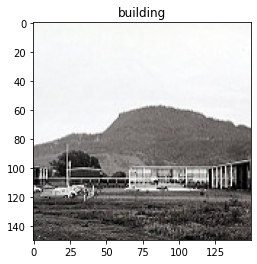

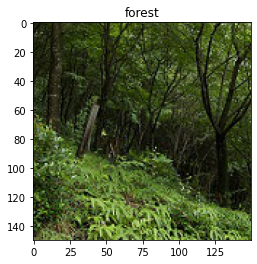

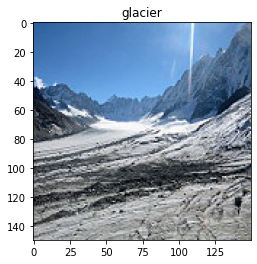

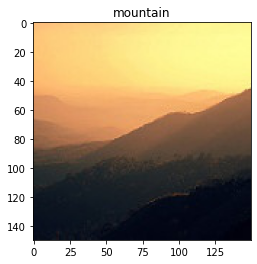

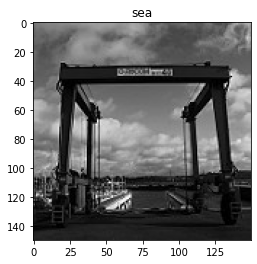

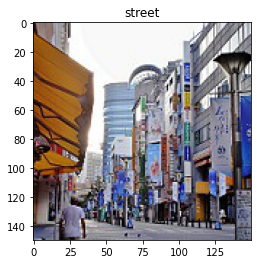

In [ ]:
ps(buildings_images,1)
ps(forest_images,1)
ps(glacier_images,1)
ps(mountain_images,1)
ps(sea_images,1)
ps(street_images,1)

In [ ]:
training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
).flow_from_directory(train,batch_size=8,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
).flow_from_directory(test,batch_size=8,target_size=(224,224),shuffle=True)

Found 14044 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [ ]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(256,activation='relu'),
    Dense(6,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1179776   
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 6)                

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=["accuracy"],optimizer='adam')
history=model.fit(training,validation_data=validing,epochs=10,batch_size=64, verbose=1)

Epoch 1/10
1756/1756 [==============================] - 4241s 2s/step - loss: 1.1205 - accuracy: 0.6404 - val_loss: 0.9213 - val_accuracy: 0.6643
Epoch 2/10
1756/1756 [==============================] - 3000s 2s/step - loss: 0.8694 - accuracy: 0.7083 - val_loss: 0.6998 - val_accuracy: 0.7743
Epoch 3/10
1756/1756 [==============================] - 3013s 2s/step - loss: 0.7483 - accuracy: 0.7410 - val_loss: 0.6040 - val_accuracy: 0.7993
Epoch 4/10
1756/1756 [==============================] - 2965s 2s/step - loss: 0.6240 - accuracy: 0.7785 - val_loss: 0.6219 - val_accuracy: 0.7807
Epoch 5/10
1756/1756 [==============================] - 2949s 2s/step - loss: 0.5725 - accuracy: 0.8014 - val_loss: 0.4606 - val_accuracy: 0.8380
Epoch 6/10
1756/1756 [==============================] - 2983s 2s/step - loss: 0.5061 - accuracy: 0.8245 - val_loss: 0.4608 - val_accuracy: 0.8483
Epoch 7/10
1756/1756 [==============================] - 2972s 2s/step - loss: 0.4756 - accuracy: 0.8364 - val_loss: 0.5037 -

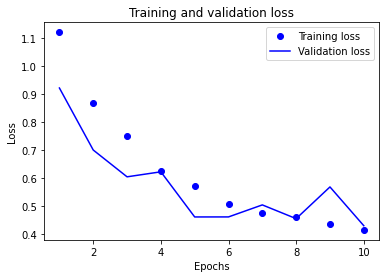

In [35]:
history_dict = history.history
history_dict.keys()

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
score = model.evaluate(validing) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

375/375 [==============================] - 169s 448ms/step - loss: 0.4325 - accuracy: 0.8533
Test score: 0.4325445294380188
Test accuracy: 0.8533333539962769


#3. Рекурентні нейронні мережі.

In [38]:
data = pd.read_csv("/content/drive/MyDrive/TMP/Lab3/Some/IMDB Dataset.csv", names=['review', 'sentiment'], header=0)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
Review_lenghts = list(map(len, data.review.values))
print('Max len ',np.max(Review_lenghts))
print('Min len ', np.min(Review_lenghts))
print('Mean size ',np.mean(Review_lenghts))
print('Median size ',np.median(Review_lenghts))

Max len  13704
Min len  32
Mean size  1309.67016
Median size  971.0


In [ ]:
print(data.sentiment.value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [ ]:
dictionary_length = 1000
input_length = 100

tokenizer = Tokenizer(num_words=dictionary_length)
tokenizer.fit_on_texts(data.review.values)

In [ ]:
post_seq = tokenizer.texts_to_sequences(data.review.values)

In [ ]:
post_seq_padded = pad_sequences(post_seq, maxlen=input_length)

In [ ]:
X = post_seq_padded
X_array = np.array(X)
Y = data['sentiment'].values
Y = 1*(Y=='positive')
Y_array = np.array(Y)

x, y = shuffle(X_array, Y_array, random_state=23)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=23)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=23)

In [ ]:
model2 = Sequential()
model2.add(Embedding(dictionary_length, 2, input_length=input_length))
model2.add(Bidirectional(SimpleRNN(16, return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(16, return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(16, return_sequences=False)))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 2)            2000      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 32)          608       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 32)          1568      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               1568      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                      

In [ ]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history2 = model2.fit(x=x_train, y=y_train, batch_size=256, verbose=1, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
110/110 [==============================] - 17s 114ms/step - loss: 0.6965 - accuracy: 0.5077 - val_loss: 0.6935 - val_accuracy: 0.5117
Epoch 2/5
110/110 [==============================] - 12s 108ms/step - loss: 0.6909 - accuracy: 0.5311 - val_loss: 0.6924 - val_accuracy: 0.5193
Epoch 3/5
110/110 [==============================] - 12s 110ms/step - loss: 0.6369 - accuracy: 0.6188 - val_loss: 0.5043 - val_accuracy: 0.7636
Epoch 4/5
110/110 [==============================] - 12s 110ms/step - loss: 0.4204 - accuracy: 0.8142 - val_loss: 0.3777 - val_accuracy: 0.8360
Epoch 5/5
110/110 [==============================] - 12s 110ms/step - loss: 0.3650 - accuracy: 0.8410 - val_loss: 0.3625 - val_accuracy: 0.8383


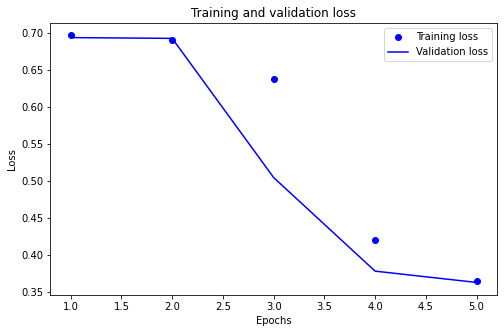

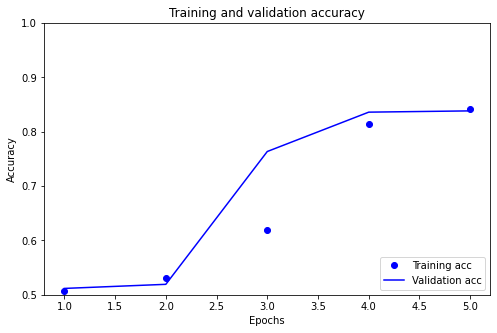

In [ ]:
history_dict = history2.history

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(8,5))
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()